In [16]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob

In [17]:
GRID_H = 9
GRID_W = 6

In [18]:
with open("cameraCal.npy", "rb") as f:
    mtx = np.load(f)
    dist = np.load(f)

class undistort:
    def __init__(self, mtx, dist):
        self.mtx = mtx
        self.dist = dist

    def undistort(self, img):
        h,  w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (w,h), 1, (w,h))

        dst = cv2.undistort(img, self.mtx, self.dist, None, newcameramtx)

        return dst

UDT = undistort(mtx, dist)

In [19]:
def get_length(p1, p2):
    return np.sqrt( (p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

In [20]:
images = glob.glob('distance/*.jpg')
images.sort()

distance = 300 # mm
distance_increment = 100
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

FRST_P = 0
SCND_P = 8
LENGTH = 22 * (SCND_P - FRST_P) # mm

lengths = []
distances = []

for fname in images:
    img = cv2.imread(fname)
    img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])

        lengths.append(length)
        distances.append(distance)

        distance += distance_increment


Text(0, 0.5, '1/Distance')

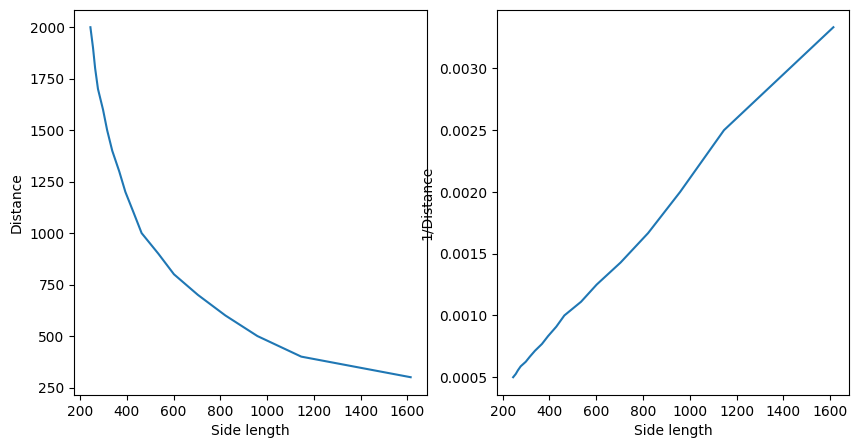

In [21]:
distances2 = [1/x for x in distances]

plt.figure(figsize=(10, 5))  # Set the figure size

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(lengths, distances)
plt.xlabel("Side length")
plt.ylabel("Distance")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(lengths, distances2)
plt.xlabel("Side length")
plt.ylabel("1/Distance")


As expected from the perspective model, the correlation between length of one side and distance is linear

In [22]:
lengths[:5], distances[:5]

([1613.5954822143494,
  1145.9753545320832,
  958.4165269529692,
  821.4850277031497,
  704.000936654387],
 [300, 400, 500, 600, 700])

In [23]:
class DistanceEstimator:
    def __init__(self, lengths, inv_distances):
        self.m, self.b = np.polyfit(lengths, inv_distances, 1)
    
    def get_distance(self, length):
        return 1 / (self.m * length + self.b)

DE = DistanceEstimator(lengths, distances2)
DE.get_distance(lengths[0])

296.73791223826083

In [24]:
def put_text(img, text, offset=0):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (2000, 500 + offset)
    fontScale = 10
    color = (255, 0, 0)
    thickness = 20
    img = cv2.putText(img, text, org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
    return img

In [25]:
objp = np.zeros((GRID_H*GRID_W,3), np.float32)
objp[:,:2] = np.mgrid[0:GRID_H,0:GRID_W].T.reshape(-1,2)

In [ ]:
imgs = []
estimated_distances = []
nums = []

for fname in images:
    img = cv2.imread(fname)
    img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (22,22), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])
        distance = DE.get_distance(length)
        estimated_distances.append(distance)
        distance = int(distance*10)
        distance /= 10

        img = put_text(img, str(distance))

        imgs.append(img)


296.7 16.182881906019542
417.6 21.869213332034033
499.3 25.891949751760478
582.3 30.15983588198853
679.5 34.93265008095778
794.6 40.56402776717076
893.5 45.4904990513666
1030.8 52.31306787635736
1113.5 56.46186549411966
1211.8 61.30295458816774
1298.9 64.86509959009061
1412.3 70.68674930147307
1509.9 75.63627203444324
1599.1 80.39376515941724
1723.0 86.05592058991083
1801.6 89.86226559617074
1863.3 93.4408882776418
1948.7 98.02584034304535


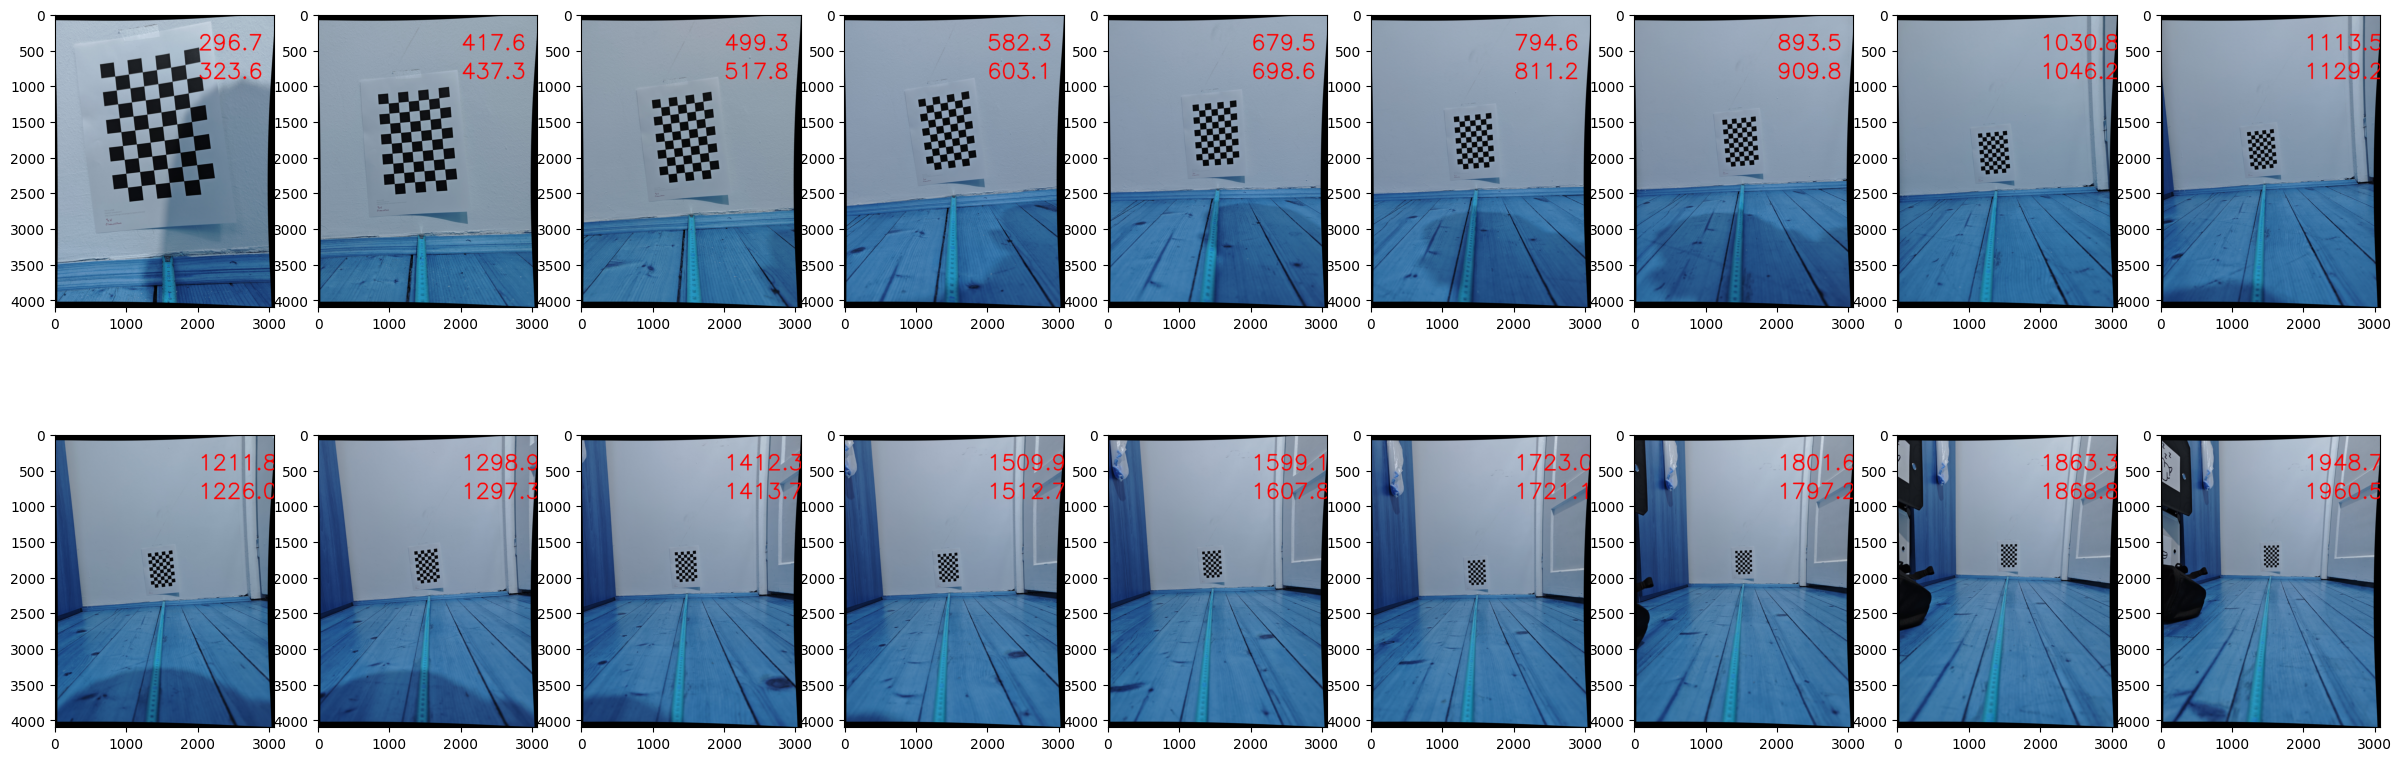

In [30]:
plt.figure(figsize=(30, 10))  # Set the figure size
i = 1

for img in imgs:
    plt.subplot(2, 9, i)

    plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    i += 1

14.692746208082553


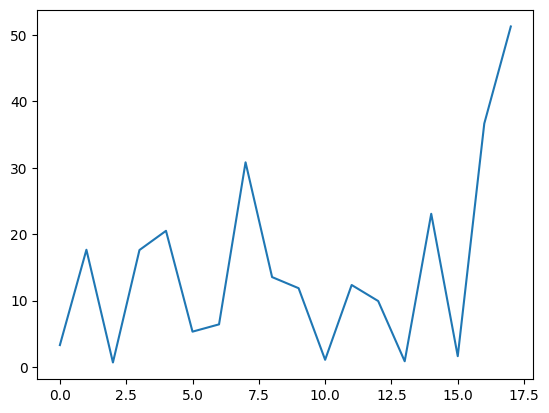

In [28]:
errors = []
distances_actual = []
distance = 300 # mm
distance_increment = 100
while distance < 2001:
    distances_actual.append(distance)
    distance += distance_increment

for i in range(len(distances)):
    error = abs(distances_actual[i] - estimated_distances[i])
    errors.append(error)

print(np.average(errors))
plt.plot(errors)

In [33]:
imgs = []
estimated_distances = []

distances_1 = []
distances_2 = []

for fname in images:
    img = cv2.imread(fname)
    img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (22,22), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])
        distance = DE.get_distance(length)
        estimated_distances.append(distance)
        distance = int(distance*10)
        distance /= 10

        img = put_text(img, str(distance))

        # ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray_image.shape[::-1], None, None)
        ret, rvec, tvec = cv2.solvePnP(objp, corners2, mtx, dist)
        # tvec is the translation vector that represents the position of the checkerboard in the camera's coordinate system.
        # The magnitude of tvec gives the distance from the camera to the checkerboard center.
        distance2 = np.linalg.norm(tvec)
        print(distance, distance2)
        distance2 /= 0.05
        distance2 = int(distance2*10)
        distance2 /= 10

        distances_1.append(distance)
        distances_2.append(distance2)

        img = put_text(img, str(distance2), 400)

        imgs.append(img)


296.7 16.182881906019542
417.6 21.869213332034033
499.3 25.891949751760478
582.3 30.15983588198853
679.5 34.93265008095778
794.6 40.56402776717076
893.5 45.4904990513666
1030.8 52.31306787635736
1113.5 56.46186549411966
1211.8 61.30295458816774
1298.9 64.86509959009061
1412.3 70.68674930147307
1509.9 75.63627203444324
1599.1 80.39376515941724
1723.0 86.05592058991083
1801.6 89.86226559617074
1863.3 93.4408882776418
1948.7 98.02584034304535


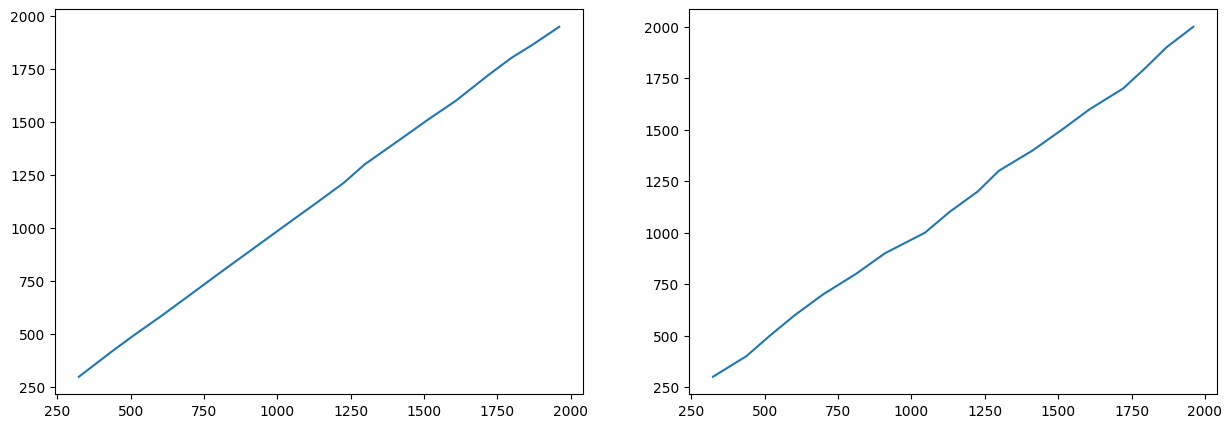

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(distances_2, distances_1)
plt.subplot(1,2,2)
plt.plot(distances_2, np.array([300 + i*100 for i in range(18)]))